# Character analysis single play

## Step 1: Prepare analysis
---
### 1.1 Load modules

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
from urllib.request import urlopen

### 1.2 Define filepath or data source

In [ ]:
URL = "https://dracor.org/api/corpora/fre/play/moliere-medecin-malgre-lui/tei"
filename = URL.split("/")[-2]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
output_folder = "/content/gdrive/My Drive/Scripties/DH theses/visualisations/"

In [ ]:
with urlopen(URL) as TEI_file:
  tree = ET.parse(TEI_file)
  root_play = tree.getroot()

### 1.3 Define functions

In [ ]:
def create_speakersdict():
    speakers_dict = {}
    speaker_list = [persona for persona in root_play.findall(".//{http://www.tei-c.org/ns/1.0}personGrp") + root_play.findall(".//{http://www.tei-c.org/ns/1.0}person")]
    for speaker in speaker_list:
        speaker_id = speaker.get("{http://www.w3.org/XML/1998/namespace}id")
        if speaker.find(".//{http://www.tei-c.org/ns/1.0}name") != None:
          name = speaker.find(".//{http://www.tei-c.org/ns/1.0}name").text
        else:
          name = speaker.find(".//{http://www.tei-c.org/ns/1.0}persName").text
        speakers_dict[speaker_id] = {}
        speakers_dict[speaker_id]["name"] = name
        speakers_dict[speaker_id]["gender"] = speaker.get("sex")
        speakers_dict[speaker_id]["act_appearances"] = 0
        speakers_dict[speaker_id]["scene_appearances"] = 0
        speakers_dict[speaker_id]["speech_turns"] = 0
        speakers_dict[speaker_id]["lines"] = 0
    return(speakers_dict)

def extract_speechturns(list_of_scenes, play_has_acts, act_ID):
    for scene in list_of_scenes:
            scene_ID = "Scene_" + scene.get("n")
            if play_has_acts:
                lines_dict[act_ID][scene_ID] = {}
            else:
                lines_dict[scene_ID] = {}
            speech_turns = [speech for speech in scene.findall(".//{http://www.tei-c.org/ns/1.0}sp")]
            speakers_in_scene = set([])

            for speech_turn in speech_turns:
                speaker_element = speech_turn.findall(".//{http://www.tei-c.org/ns/1.0}speaker")

                if speech_turn.get("who") == None:
                  speaker_id = "UNKNOWN"
                else:
                  speaker_id = speech_turn.get("who").replace("#", "")

                if play_has_acts:
                    speakers_in_act.add(speaker_id)
                speakers_in_scene.add(speaker_id)
                lines = speech_turn.findall(".//{http://www.tei-c.org/ns/1.0}lb") + speech_turn.findall(".//{http://www.tei-c.org/ns/1.0}l") + speech_turn.findall(".//{http://www.tei-c.org/ns/1.0}s")

                if speaker_id not in speakers_dict:
                    speakers_dict[speaker_id] = {}
                    speakers_dict[speaker_id]["name"] = "UNKNOWN"
                    speakers_dict[speaker_id]["gender"] = "u"
                    speakers_dict[speaker_id]["act_appearances"] = 0
                    speakers_dict[speaker_id]["scene_appearances"] = 0
                    speakers_dict[speaker_id]["speech_turns"] = 0
                    speakers_dict[speaker_id]["lines"] = 0
                speakers_dict[speaker_id]["speech_turns"] += 1
                speakers_dict[speaker_id]["lines"] += len(lines)

                if play_has_acts:
                    if speaker_id not in lines_dict[act_ID][scene_ID]:
                        lines_dict[act_ID][scene_ID][speaker_id] = len(lines)
                    else:
                        lines_dict[act_ID][scene_ID][speaker_id] += len(lines)
                else:
                    if speaker_id not in lines_dict[scene_ID]:
                        lines_dict[scene_ID][speaker_id] = len(lines)
                    else:
                        lines_dict[scene_ID][speaker_id] += len(lines)
            for speaker_id in speakers_in_scene:
                speakers_dict[speaker_id]["scene_appearances"] += 1

def generate_edges(speaker_ids):
    for source_id in speaker_ids:
            if source_id not in edges_dict:
                edges_dict[source_id] = {}
            for target_id in speaker_ids:
                if target_id != source_id:
                    if target_id in edges_dict:
                        if source_id in edges_dict[target_id]:
                            ()
                        elif target_id not in edges_dict[source_id]:
                            edges_dict[source_id][target_id] = 1
                        else:
                            edges_dict[source_id][target_id] += 1
                    elif target_id not in edges_dict[source_id]:
                        edges_dict[source_id][target_id] = 1
                    else:
                        edges_dict[source_id][target_id] += 1

In [ ]:
speakers_dict = create_speakersdict()
lines_dict = {}
list_of_acts = [act for act in root_play.findall(".//{http://www.tei-c.org/ns/1.0}div[@type='act']") + root_play.findall(".//{http://www.tei-c.org/ns/1.0}div[@type='prologue']")]


if len(list_of_acts) > 0:
    play_has_acts = True
else:
    play_has_acts = False

if play_has_acts:
    for act in list_of_acts:
        act_ID = "Act_" + act.get("n")
        lines_dict[act_ID] = {}
        list_of_scenes = [scene for scene in act.findall(".//{http://www.tei-c.org/ns/1.0}div[@type='scene']")]
        speakers_in_act = set([])
        extract_speechturns(list_of_scenes, play_has_acts, act_ID)

        for speaker_id in speakers_in_act:
          speakers_dict[speaker_id]["act_appearances"] += 1

else:
    act_ID = 0
    list_of_scenes = [scene for scene in root_play.findall(".//{http://www.tei-c.org/ns/1.0}div[@type='scene']")]
    extract_speechturns(list_of_scenes, play_has_acts, act_ID)

data_matrix = []
speaker_ids = list(speakers_dict.keys())

for speaker_id in speaker_ids:
    if play_has_acts:
        lines_per_act_per_char = []
        for act in lines_dict:
            lines_per_char = 0
            for scene in lines_dict[act]:
                if speaker_id in lines_dict[act][scene]:
                    lines_per_char += lines_dict[act][scene][speaker_id]
            lines_per_act_per_char.append(lines_per_char)
        data_matrix.append(lines_per_act_per_char)
    else:
        lines_per_scene_per_char = []
        for scene in lines_dict:
            if speaker_id in lines_dict[scene]:
                lines_per_char = lines_dict[scene][speaker_id]
            else:
                lines_per_char = 0
            lines_per_scene_per_char.append(lines_per_char)
        data_matrix.append(lines_per_scene_per_char)

speakers_dict_sorted = {k: v for k, v in sorted(speakers_dict.items(), key=lambda item: item[1]["lines"], reverse=True)}
header = list(speakers_dict[speaker_ids[0]].keys())
speakers = []

for speaker_id in speakers_dict_sorted:
    row = [speaker_id] + list(speakers_dict[speaker_id].values())
    speakers.append(row)

df_speakers = pd.DataFrame([row[1:] for row in speakers], columns=header, index=[row[0] for row in speakers])
print("Characters in ", filename, "ordered by # lines \n")
#df_speakers.to_csv(output_folder + "Data_per_toneelstuk/PERSONAGES_" + filename + ".csv")
df_speakers


Characters in  moliere-medecin-malgre-lui ordered by # lines 



,name,gender,act_appearances,scene_appearances,speech_turns,lines
sganarelle,Sganarelle,MALE,3,16,226,349
geronte,Géronte,MALE,2,11,110,140
martine,Martine,FEMALE,2,6,65,85
valere,Valère,MALE,2,4,63,79
lucas,Lucas,MALE,3,9,50,62
jacqueline,Jacqueline,FEMALE,2,5,18,26
lucinde,Lucinde,FEMALE,2,2,16,22
leandre,Léandre,MALE,2,3,16,20
monsieur-robert,Monsieur Robert,MALE,1,1,16,19
thibaut,Thibaut,MALE,1,1,6,11


In [ ]:
scene_numbers = []
male_lines_list = []
female_lines_list = []

scene_counter = 0
for act_ID in lines_dict:
  for scene_ID in lines_dict[act_ID]:
    male_lines = 0
    female_lines = 0
    characters_in_scene = list(lines_dict[act_ID][scene_ID].keys())
    for character_ID in characters_in_scene:
      character_gender = speakers_dict[character_ID]["gender"]
      if character_gender == "MALE":
        male_lines += lines_dict[act_ID][scene_ID][character_ID]
      if character_gender == "FEMALE":
        female_lines += lines_dict[act_ID][scene_ID][character_ID]
    scene_counter += 1
    scene_numbers.append(scene_counter)
    male_lines_list.append(male_lines)
    female_lines_list.append(female_lines)
    #print(scene_counter, male_lines, female_lines)

print(scene_numbers)
print(male_lines_list)
print(female_lines_list)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[29, 37, 0, 28, 155, 30, 64, 16, 126, 27, 21, 35, 15, 5, 17, 37, 21, 7, 6, 4, 6]
[26, 21, 3, 26, 0, 10, 0, 1, 10, 0, 0, 0, 7, 0, 0, 20, 0, 0, 8, 0, 1]


## Step 3: Analysis and visualisation
---
### 3.1 Character dispersion

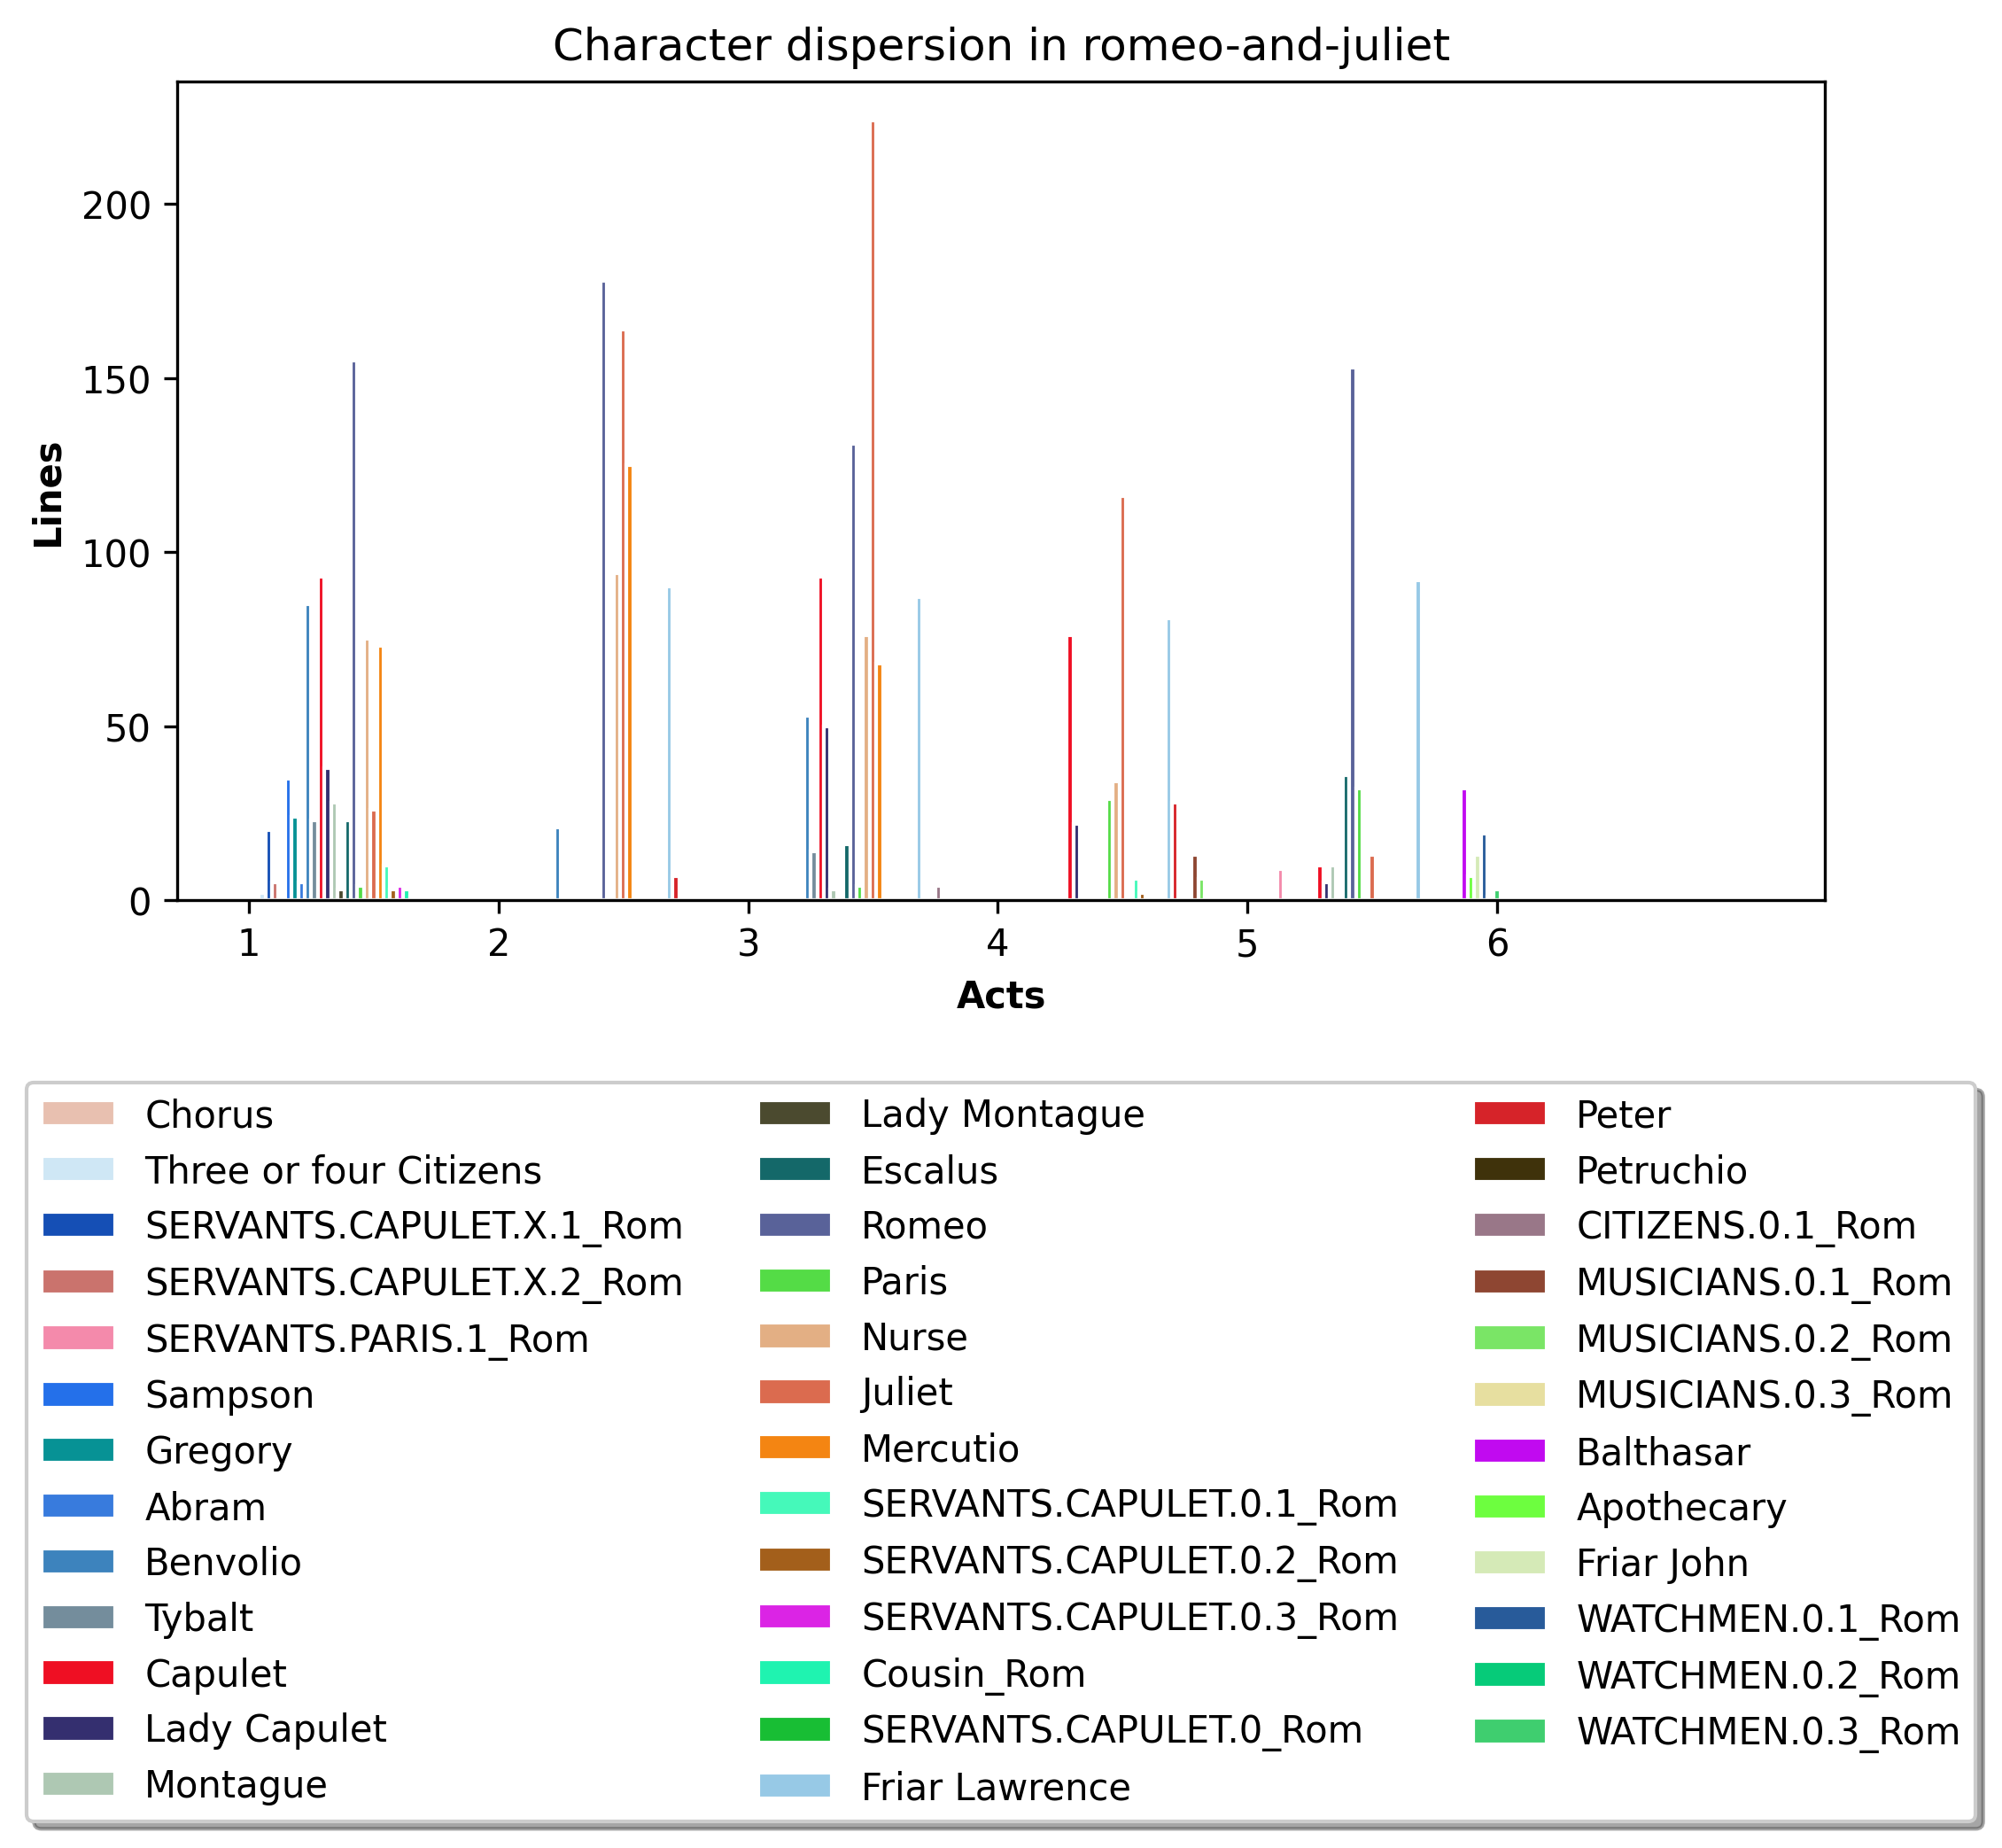

In [ ]:
# set width of bars
barWidth = 0.25

fig = plt.figure(figsize=(8,4), dpi=300)

speaker_names = [speakers_dict[speaker_id]["name"] for speaker_id in list(speakers_dict.keys())]
positions = []
positions.append([x*len(speaker_names)*barWidth for x in range(len(data_matrix[1]))])

for i in range(len(speaker_names)):

    r = [x+barWidth for x in positions[i]]
    positions.append(r)

    col = (np.random.random(), np.random.random(), np.random.random())

    plt.bar(r, data_matrix[i], color=col, width=barWidth, edgecolor="white", label=speaker_names[i])

plt.title("Character dispersion in " + filename)
plt.xticks([r*len(speaker_names) * barWidth for r in range(len(data_matrix[1]))], [i+1 for i in range(len(lines_dict))])
plt.ylabel('Lines', fontweight='bold')
if play_has_acts:
    plt.xlabel('Acts', fontweight='bold')
else:
    plt.xlabel('Scenes', fontweight='bold')


# Create legend & Show graphic

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

plt.show()
#fig.savefig(output_folder + "Visualisaties/CHARACTER_DISPERSION_" + filename +".png", bbox_inches='tight') #save the file

### 3.2 Network analysis

#### 3.2.1 Create network graph

In [ ]:
G = nx.Graph()

# Create nodes

for speaker_id in speakers_dict:
    G.add_node(speaker_id,
               name=speakers_dict[speaker_id]["name"],
               gender=speakers_dict[speaker_id]["gender"],
               act_appearances = speakers_dict[speaker_id]["act_appearances"],
               scene_appearances = speakers_dict[speaker_id]["scene_appearances"],
               speech_turns = speakers_dict[speaker_id]["speech_turns"],
               lines=speakers_dict[speaker_id]["lines"])

# Create edges

edges_dict = {}

if play_has_acts:
    for act in lines_dict:
        for scene in lines_dict[act]:
            speaker_ids = lines_dict[act][scene].keys()
            speaker_values = lines_dict[act][scene].values()
            generate_edges(speaker_ids)

else:
    for scene in lines_dict:
        speaker_ids = lines_dict[scene].keys()
        speaker_values = lines_dict[scene].values()
        generate_edges(speaker_ids)


for source_id in edges_dict:
    for target_id in edges_dict[source_id]:
        weight = edges_dict[source_id][target_id]
        G.add_edge(source_id, target_id, weight=edges_dict[source_id][target_id])

for k,v in G.degree:
    G.nodes[k]["degree"] = v

print("NODES: \n", G.nodes(data=True), "\n")
print("EDGES: \n", G.edges(data=True))

NODES: 
 [('sganarelle', {'name': 'Sganarelle', 'gender': 'MALE', 'act_appearances': 3, 'scene_appearances': 16, 'speech_turns': 226, 'lines': 349, 'degree': 10}), ('martine', {'name': 'Martine', 'gender': 'FEMALE', 'act_appearances': 2, 'scene_appearances': 6, 'speech_turns': 65, 'lines': 85, 'degree': 6}), ('monsieur-robert', {'name': 'Monsieur Robert', 'gender': 'MALE', 'act_appearances': 1, 'scene_appearances': 1, 'speech_turns': 16, 'lines': 19, 'degree': 2}), ('lucas', {'name': 'Lucas', 'gender': 'MALE', 'act_appearances': 3, 'scene_appearances': 9, 'speech_turns': 50, 'lines': 62, 'degree': 6}), ('valere', {'name': 'Valère', 'gender': 'MALE', 'act_appearances': 2, 'scene_appearances': 4, 'speech_turns': 63, 'lines': 79, 'degree': 5}), ('geronte', {'name': 'Géronte', 'gender': 'MALE', 'act_appearances': 2, 'scene_appearances': 11, 'speech_turns': 110, 'lines': 140, 'degree': 7}), ('jacqueline', {'name': 'Jacqueline', 'gender': 'FEMALE', 'act_appearances': 2, 'scene_appearances': 

#### 3.2.2 Visualise network graph

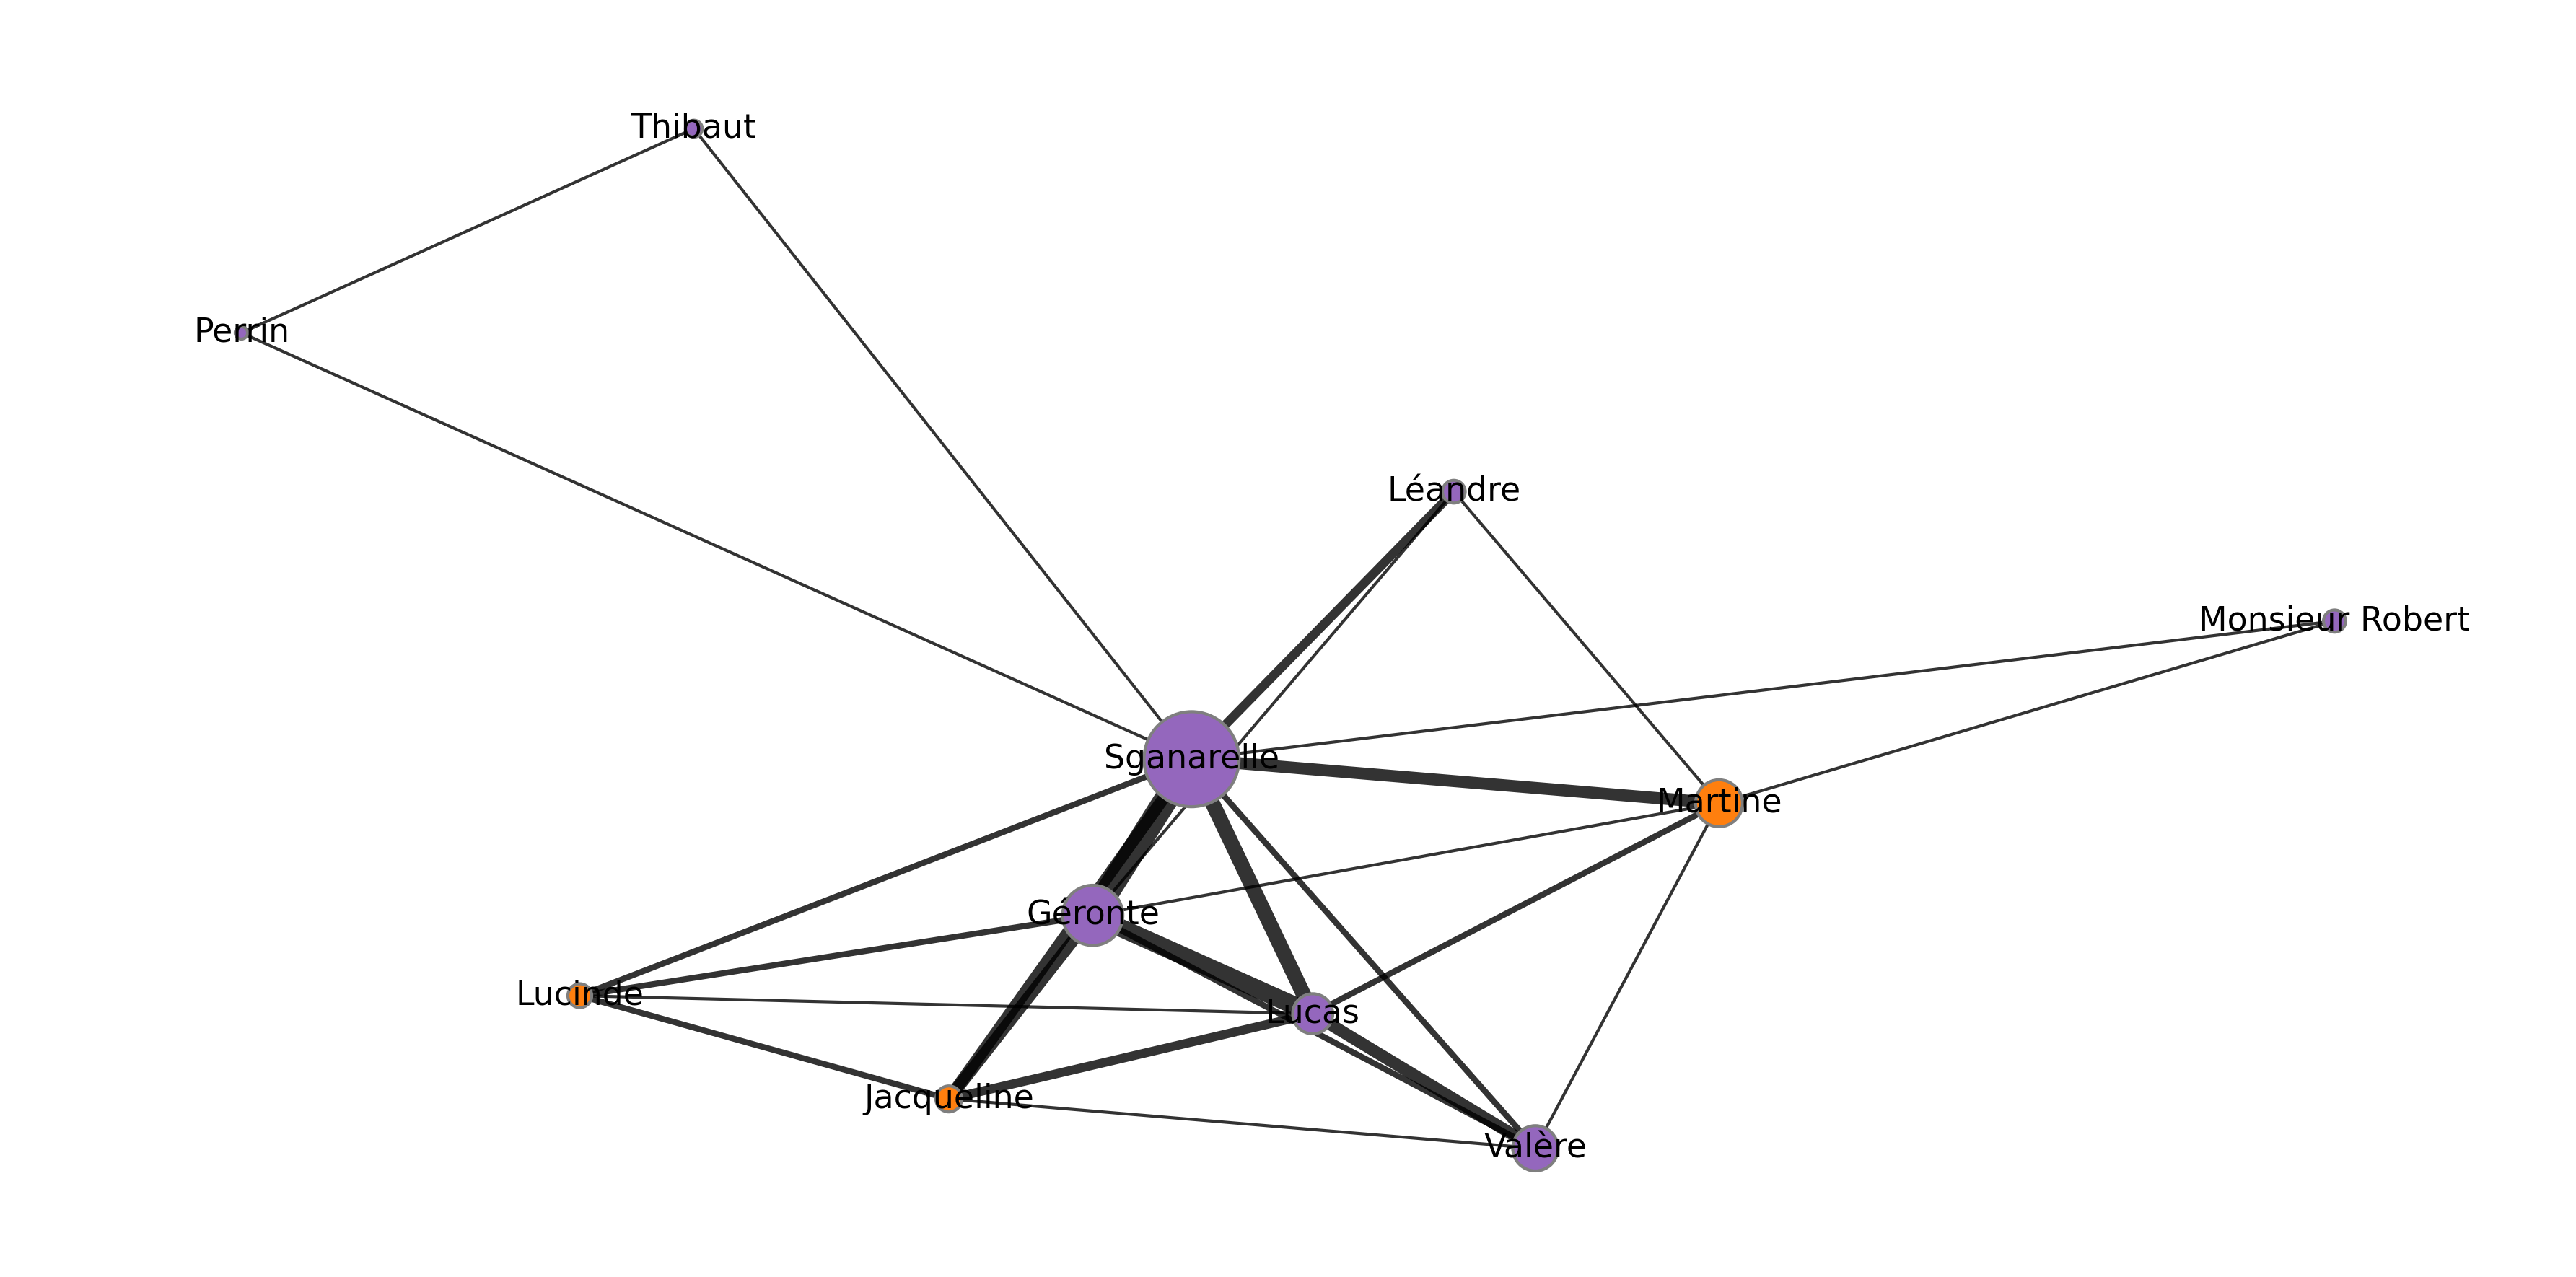

Node size attribute = lines
Node color attribute = gender


In [ ]:
node_size_attribute = "lines"

lines_threshold = 0

male_nodes = {k: v for k, v in G.nodes.items() if G.nodes[k]["gender"] == "MALE" and G.nodes[k]["lines"] > lines_threshold }
female_nodes = {k: v for k, v in G.nodes.items() if G.nodes[k]["gender"] == "FEMALE" and G.nodes[k]["lines"] > lines_threshold}
unknown_gender_nodes = {k: v for k, v in G.nodes.items() if G.nodes[k]["gender"] == "UNKNOWN" and G.nodes[k]["lines"] > lines_threshold}

attributes = nx.get_node_attributes(G, node_size_attribute)
sorted_values = {k: v for k, v in sorted(attributes.items(), key=lambda item: item[1])}


male_node_sizes = [attributes[k] for k in attributes if k in male_nodes]
female_node_sizes = [attributes[k] for k in attributes if k in female_nodes]
unknown_node_sizes = [attributes[k] for k in attributes if k in unknown_gender_nodes]

names_dict = nx.get_node_attributes(G, "name")

weights = [G[u][v]['weight'] for u,v in G.edges()]

fig = plt.figure(figsize=(12,6), dpi=300)
scaler = list(sorted_values.values())[-1]
default_node_size = 1000

pos = nx.spring_layout(G, seed=245)  # positions for all nodes
#pos = nx.kamada_kawai_layout(G)
#pos = nx.shell_layout(G)

# nodes
options = {"edgecolors": "tab:gray", "alpha": 1.0}
nx.draw_networkx_nodes(G, pos, nodelist=list(female_nodes.keys()), node_color="tab:orange", node_size=[v/scaler * default_node_size for v in female_node_sizes], **options)
nx.draw_networkx_nodes(G, pos, nodelist=list(male_nodes.keys()), node_color="tab:purple", node_size=[v/scaler * default_node_size for v in male_node_sizes], **options)
nx.draw_networkx_nodes(G, pos, nodelist=list(unknown_gender_nodes.keys()), node_color="tab:green", node_size=[v/scaler * default_node_size for v in unknown_node_sizes], **options)

nx.draw_networkx_edges(G, pos, width=weights, alpha=0.8)

nx.draw_networkx_labels(G, pos, labels=names_dict, font_size=11, font_color="black")


plt.axis("off")
plt.tight_layout()
plt.show()

print("Node size attribute =", node_size_attribute)
print("Node color attribute = gender")
fig.savefig(output_folder + filename +".png", bbox_inches='tight') #save the file

In [ ]:
for u,v in G.edges():
  print(u, v)



emilie fulvie
emilie cinna
emilie maxime
emilie evandre
emilie auguste
emilie livie
cinna maxime
cinna evandre
cinna auguste
cinna livie
auguste maxime
auguste euphorbe
auguste polyclete
auguste livie
maxime euphorbe
maxime livie
euphorbe polyclete


In [ ]:
my_list = [list(male_nodes.keys()) + list(female_nodes.keys()) + list(unknown_gender_nodes.keys())]

In [ ]:
'emilie' in my_list[0]

True